In [207]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [208]:
base_df = pd.read_csv("data/base_df.csv")

In [209]:
#base_df["credits_delay_count"] = base_df["credits_delay_count"].apply(lambda x: max(0, x - 1))
#base_df["cards_delay_count"] = base_df["cards_delay_count"].apply(lambda x: max(0, x - 1))
#base_df["paid_off_count"] = base_df["paid_off_count"].apply(lambda x: max(0, x - 1))

In [210]:
#base_df = base_df.drop(columns=["credits_delay_count",
#                                "cards_delay_count",
#                                "paid_off_count",
#                                "active_sum",
#                                "max_term",])

In [211]:
df_delay_0 = base_df[base_df['DELAY'] == 0]
df_delay_1 = base_df[base_df['DELAY'] == 1]

min_size = min(len(df_delay_0), len(df_delay_1))

df_delay_0_sample = df_delay_0.sample(n=min_size, random_state=42).reset_index(drop=True)
df_delay_1_sample = df_delay_1.sample(n=min_size, random_state=42).reset_index(drop=True)

balanced_df = pd.concat([df_delay_0_sample, df_delay_1_sample]).reset_index(drop=True)
balanced_df = shuffle(balanced_df, random_state=42).reset_index(drop=True)

In [213]:
balanced_df.head()

,CLIENT_ID,AGE,MAN,INCOME,IP_FLAG,SME_FLAG,REFUGEE_FLAG,PDN,paid_off_count,active_count,...,credits_delay_count,cards_count,cards_delay_count,MATRIAL_Вдовец / Вдова,MATRIAL_Гражданский брак,MATRIAL_Женат / замужем,MATRIAL_Не женат / не замужем,MATRIAL_Неизвестно,MATRIAL_Разведен / Разведена,DELAY
0,9700,56,1,80000,0,0,0,28.0,1,0,...,1,0,0,0,0,0,0,1,0,True
1,10950,30,1,55000,0,0,0,35.3,1,1,...,2,0,0,0,0,0,0,1,0,True
2,6595,21,1,85000,0,0,0,21.2,0,0,...,0,0,0,0,0,0,1,0,0,False
3,31414,56,1,28000,0,0,0,39.2,0,0,...,0,0,0,1,0,0,0,0,0,False
4,12683,29,0,100000,0,0,0,151.0,1,0,...,1,0,0,0,0,0,0,1,0,True


# For old users

In [214]:
balanced_df["credits_delay_count"] = balanced_df["credits_delay_count"].apply(lambda x: max(0, x - 1))
#base_df["cards_delay_count"] = base_df["cards_delay_count"].apply(lambda x: max(0, x - 1))
balanced_df["paid_off_count"] = balanced_df["paid_off_count"].apply(lambda x: max(0, x - 1))

In [215]:
X = balanced_df.drop(columns=['DELAY', 'CLIENT_ID'])
y = balanced_df.DELAY

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(567, 20) (567, 20) (567,) (567,)


In [216]:
old_rf = RandomForestClassifier(random_state=42,
                            max_depth=14,
                            n_estimators=1000,
                            criterion="entropy")

old_rf.fit(X_train, y_train)
print(f"Train: {old_rf.score(X_train, y_train):.10f} | Test: {old_rf.score(X_test, y_test):.10f}")

Train: 0.9982363316 | Test: 0.8536155203


In [217]:
pd.DataFrame(
    data=rf.feature_importances_,
    index=list(X),
    columns=["weight"]
).sort_values("weight", ascending=False).head(10)

,weight
max_term,0.187404
cards_delay_count,0.165041
active_sum,0.104788
PDN,0.095801
INCOME,0.083287
AGE,0.082835
MATRIAL_Неизвестно,0.060729
active_count,0.054334
credits_delay_count,0.054021
cards_count,0.052198


In [ ]:
joblib.dump(rf, 'params/rf_model_old_user.joblib')

# For new users

In [218]:
balanced_df = balanced_df.drop(columns=["credits_delay_count",
                                "cards_delay_count",
                                "paid_off_count",
                                "active_sum",
                                "max_term",])

In [219]:
X = balanced_df.drop(columns=['DELAY', 'CLIENT_ID'])
y = balanced_df.DELAY

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(850, 15) (284, 15) (850,) (284,)


Дерево

In [142]:
%%time
dt_selector = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": range(1, 11),
        "min_samples_split": range(2, 17),
        "min_samples_leaf": range(1, 17),
    },
    cv=10,
    n_jobs=-1,
    verbose=2,
    n_iter=128,
)

dt_selector.fit(X_train, y_train)

print(dt_selector.best_estimator_.score(X_train, y_train),
      dt_selector.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
0.7047058823529412 0.6654929577464789
CPU times: total: 516 ms
Wall time: 3.51 s


In [143]:
dt_selector.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=15,
                       min_samples_split=9, random_state=42)

In [220]:
dt = DecisionTreeClassifier(random_state=42,
                            max_depth=3,
                            criterion="entropy")

dt.fit(X_train, y_train)
print(f"Train: {dt.score(X_train, y_train):.10f} | Test: {dt.score(X_test, y_test):.10f}")

Train: 0.6670588235 | Test: 0.6373239437


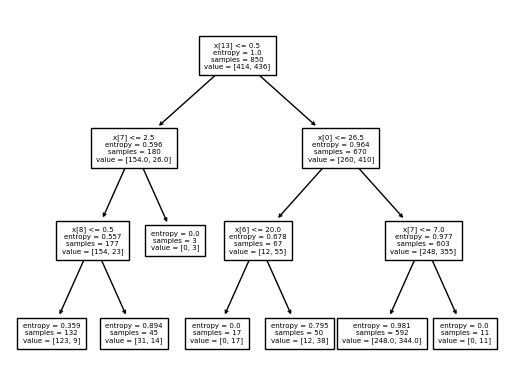

In [221]:
plot_tree(dt, fontsize=5);

In [146]:
pd.DataFrame({'Feature': X_train.columns, 'Importance': dt.feature_importances_}).sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
13,MATRIAL_Неизвестно,0.684150
7,active_count,0.120938
8,cards_count,0.077669
0,AGE,0.077081
6,PDN,0.040163
1,MAN,0.000000
2,INCOME,0.000000
3,IP_FLAG,0.000000
4,SME_FLAG,0.000000
5,REFUGEE_FLAG,0.000000


Лес

In [147]:
%%time
rf_selector = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, criterion='entropy'),
    {
        #"criterion": ["gini", "entropy", "log_loss"],
        "max_depth": range(1, 17),
        #"n_estimators": range(8, 1024 + 1),
    },
    cv=5,
    n_jobs=-1,
    verbose=2,
    n_iter=16,
)

rf_selector.fit(X_train, y_train)

print(rf_selector.best_estimator_.score(X_train, y_train),
      rf_selector.best_estimator_.score(X_test, y_test))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.8858823529411765 0.704225352112676
CPU times: total: 312 ms
Wall time: 6.12 s


In [148]:
rf_selector.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=11, random_state=42)

In [222]:
rf = RandomForestClassifier(random_state=42,
                            max_depth=14,
                            n_estimators=1000,
                            criterion="entropy")

rf.fit(X_train, y_train)
print(f"Train: {rf.score(X_train, y_train):.10f} | Test: {rf.score(X_test, y_test):.10f}")

Train: 0.9635294118 | Test: 0.7112676056


In [150]:
pd.DataFrame(
    data=rf.feature_importances_,
    index=list(X),
    columns=["weight"]
).sort_values("weight", ascending=False).head(10)

,weight
PDN,0.260986
AGE,0.208229
INCOME,0.204794
MATRIAL_Неизвестно,0.095258
active_count,0.066768
cards_count,0.049848
MATRIAL_Не женат / не замужем,0.040682
MATRIAL_Женат / замужем,0.036149
MAN,0.024099
MATRIAL_Разведен / Разведена,0.010094


In [223]:
joblib.dump(rf, 'params/rf_model_new_user.joblib')

['params/rf_model_new_user.joblib']

# Дальше тесты других моделей
xgb

In [156]:
%%time
xg_selector = GridSearchCV(
    XGBClassifier(random_state=42, max_depth=3),
    {
        #"max_depth": range(1, 17),
        "n_estimators": range(100, 1001, 100),
    },
    cv=10,
    n_jobs=-1,
    verbose=2,
)

xg_selector.fit(X_train, y_train)

print(xg_selector.best_estimator_.score(X_train, y_train),
      xg_selector.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
0.9423529411764706 0.6373239436619719
CPU times: total: 438 ms
Wall time: 7.64 s


In [158]:
xgc = XGBClassifier(random_state=42, max_depth=3, n_estimators=256)
xgc.fit(X_train, y_train)

print(xgc.score(X_train, y_train), xgc.score(X_test, y_test))

0.9588235294117647 0.6443661971830986


In [157]:
xg_selector.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

cb

In [159]:
%%time
cb_selector = GridSearchCV(
    CatBoostClassifier(random_state=42, verbose=0, iterations=256),
    {
        #"max_depth": range(1, 17),
        #"n_estimators": range(90, 120),
        "depth": range(2, 11),
    },
    cv=10,
    n_jobs=-1,
    verbose=2,
)

cb_selector.fit(X_train, y_train)

print(cb_selector.best_estimator_.score(X_train, y_train),
      cb_selector.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
0.78 0.6584507042253521
CPU times: total: 766 ms
Wall time: 32.1 s


In [166]:
cb = CatBoostClassifier(iterations=1000, depth=6, verbose=0)
cb.fit(X_train, y_train)

print(cb.score(X_train, y_train), cb.score(X_test, y_test))

0.8694117647058823 0.7077464788732394


In [160]:
cb_selector.best_estimator_.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 256,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [False, True],
 'random_seed': 42,
 'depth': 4,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 

In [171]:
for lim in np.linspace(0, 1, 20):
    pred = []
    for f, t in rf.predict_proba(X_test):
        if f > lim:
            pred.append(0)
        else:
            pred.append(1)

    print(f"{lim:.5f} | {accuracy_score(pred, y_test):.10f}")

0.00000 | 0.5387323944
0.05263 | 0.5492957746
0.10526 | 0.5704225352
0.15789 | 0.5880281690
0.21053 | 0.5950704225
0.26316 | 0.6021126761
0.31579 | 0.6408450704
0.36842 | 0.6443661972
0.42105 | 0.6725352113
0.47368 | 0.7077464789
0.52632 | 0.7042253521
0.57895 | 0.6549295775
0.63158 | 0.6619718310
0.68421 | 0.6338028169
0.73684 | 0.6232394366
0.78947 | 0.6056338028
0.84211 | 0.5880281690
0.89474 | 0.5633802817
0.94737 | 0.4964788732
1.00000 | 0.4612676056


In [ ]:
xgc.predict_proba(X_test)

In [ ]:
xgc.predict(X_test.iloc[29:30])

In [ ]:
y_test[20:40]

In [ ]:
X_test.iloc[29:30].T

In [172]:
joblib.dump(rf, 'params/rf_model.joblib')

['params/rf_model.joblib']

In [ ]:
xgc.predict(X_test.iloc[20:40])

In [35]:
joblib.dump(xgc, 'params/xgb_model.joblib')

['params/xgb_model.joblib']

In [36]:
joblib.dump(dt, 'params/dt_model.joblib')

['params/dt_model.joblib']

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AGE                            7121 non-null   int64  
 1   MAN                            7121 non-null   int64  
 2   INCOME                         7121 non-null   int64  
 3   IP_FLAG                        7121 non-null   int64  
 4   SME_FLAG                       7121 non-null   int64  
 5   REFUGEE_FLAG                   7121 non-null   int64  
 6   PDN                            7121 non-null   float64
 7   paid_off_count                 7121 non-null   int64  
 8   active_count                   7121 non-null   int64  
 9   active_sum                     7121 non-null   float64
 10  max_term                       7121 non-null   int64  
 11  credits_delay_count            7121 non-null   int64  
 12  cards_count                    7121 non-null   i